In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [32]:
cryto = 'BTC'
currency= 'USD'

start = dt.datetime(2020,1,1) #(2019,1,1)
end= dt.datetime.now() #(2021,1,1)

data= web.DataReader(f'{cryto}-{currency}', 'yahoo', start, end)
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-10-14,19889.146484,19115.408203,19382.533203,19185.656250,38452356727,19185.656250
2022-10-15,19212.541016,19019.250000,19185.437500,19067.634766,16192235532,19067.634766
2022-10-16,19389.603516,19068.914062,19068.914062,19268.093750,17988916650,19268.093750
2022-10-17,19635.802734,19173.333984,19268.562500,19550.757812,27472552998,19550.757812
2022-10-18,19600.962891,19501.566406,19562.869141,19502.236328,27608111104,19502.236328


In [73]:
#Prep Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data= scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days= 60

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [36]:
#Neural Network
model= Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
31/31 [==============================] - 15s 192ms/step - loss: 0.0391
Epoch 2/25
31/31 [==============================] - 6s 203ms/step - loss: 0.0086
Epoch 3/25
31/31 [==============================] - 6s 193ms/step - loss: 0.0079
Epoch 4/25
31/31 [==============================] - 6s 197ms/step - loss: 0.0080
Epoch 5/25
31/31 [==============================] - 6s 180ms/step - loss: 0.0061
Epoch 6/25
31/31 [==============================] - 6s 179ms/step - loss: 0.0062
Epoch 7/25
31/31 [==============================] - 6s 184ms/step - loss: 0.0055
Epoch 8/25
31/31 [==============================] - 6s 183ms/step - loss: 0.0053
Epoch 9/25
31/31 [==============================] - 6s 178ms/step - loss: 0.0054
Epoch 10/25
31/31 [==============================] - 6s 198ms/step - loss: 0.0049
Epoch 11/25
31/31 [==============================] - 5s 157ms/step - loss: 0.0043
Epoch 12/25
31/31 [==============================] - 5s 174ms/step - loss: 0.0064
Epoch 13/25
31/31 [=====

32/32 [==============================] - 3s 46ms/step


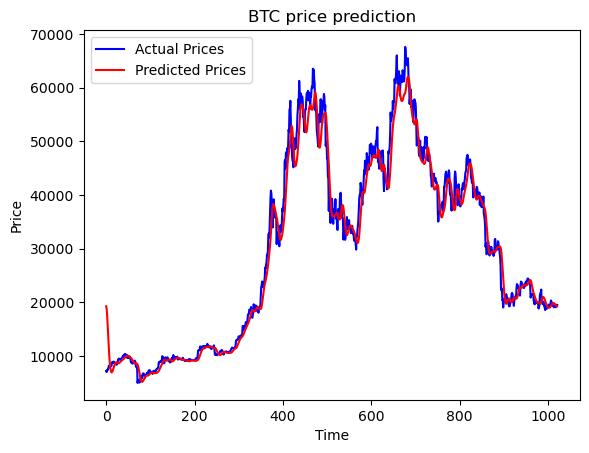

In [37]:
#test model
test_start= dt.datetime(2020,1,1)#(2022,1,1)
test_end= dt.datetime.now()

test_data= web.DataReader(f'{cryto}-{currency}', 'yahoo', test_start, test_end)
actual_prices= test_data['Close'].values

total_dataset= pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs= total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs= model_inputs.reshape(-1,1)
model_inputs= scaler.fit_transform(model_inputs)

x_test= []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test= np.array(x_test)
x_test= np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices= model.predict(x_test)
prediction_prices= scaler.inverse_transform(prediction_prices)

plt.plot(actual_prices, color='blue', label='Actual Prices')
plt.plot(prediction_prices, color='red', label='Predicted Prices')
plt.title(f'{cryto} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()


In [40]:
#predict next day 
real_data= [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs) + 1, 0]]
real_data= np.array(real_data)
real_data= np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction= model.predict(real_data)
prediction= scaler.inverse_transform(prediction)
prediction

1/1 [==============================] - 0s 69ms/step


array([[19250.635]], dtype=float32)

In [124]:
#test model
test_start= dt.datetime(2021,1,1)
test_end= dt.datetime(2022,1,1)

test_data= web.DataReader(f'{cryto}-{currency}', 'yahoo', test_start, test_end)
actual_prices= test_data['Close'].values

# # total_dataset= pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs= test_data[len(test_data) - prediction_days:].values
model_inputs= model_inputs.reshape(-1,1)
model_inputs= scaler.fit_transform(model_inputs)

x_test= []
y_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    y_test.append(model_inputs[x, 0])


x_test= np.array(x_test)
x_test= np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices= model.predict(x_test)

10/10 [==============================] - 0s 32ms/step


In [125]:
real_prices = scaler.inverse_transform(np.array(y_test).reshape(1,-1))

In [126]:
predicted_prices_raw = scaler.inverse_transform(prediction_prices)

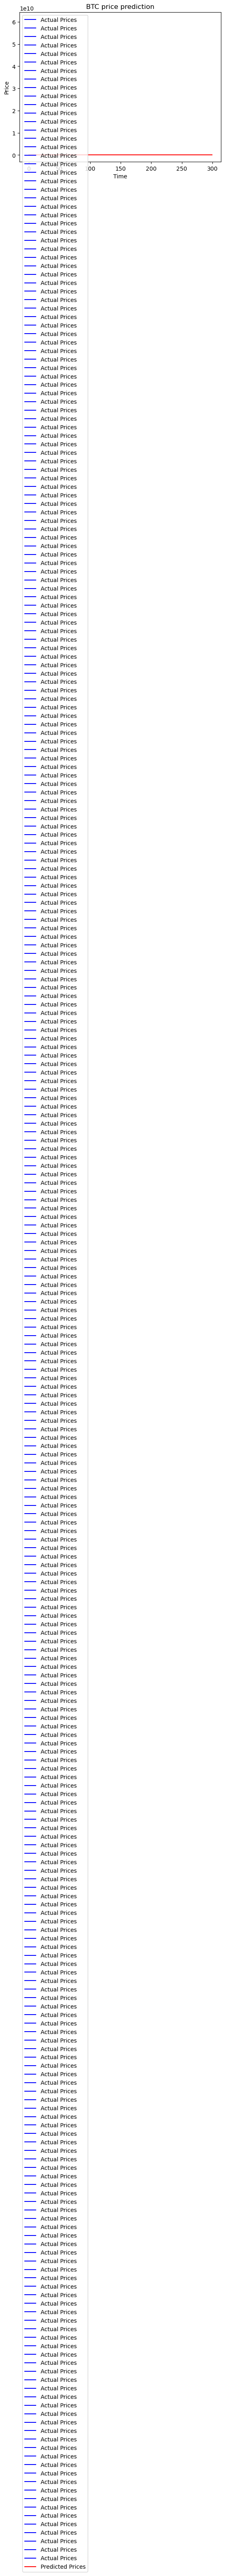

In [127]:
plt.plot(real_prices, color='blue', label='Actual Prices')
plt.plot(prediction_prices_raw, color='red', label='Predicted Prices')
plt.title(f'{cryto} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()
